In [23]:
import os
import tensorflow as tf

BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (299, 299)
SEED = 42

def extract_family_genus_and_species_from_path(path):
    # TensorFlow operation to extract the folder name from the full path
    parts = tf.strings.split(path, os.sep)
    folder_name = parts[
        -2
    ]  # Assumes the structure '/.../family_genus_species/image.jpg'

    # Split the folder name assuming the format "family_genus_species"
    family_genus_species = tf.strings.split(folder_name, "_")
    family = family_genus_species[-3]
    genus = family_genus_species[-2]
    species = family_genus_species[-2] + " " + family_genus_species[-1]

    return family, genus, species

def process_path(path, family_labels, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)

    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to the desired size
    img = tf.image.resize(img, [299, 299])

    # Get the family, genus, and species labels
    family, genus, species = extract_family_genus_and_species_from_path(path)

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset(directory, batch_size=32):
    # Get list of all files and extract labels
    file_paths = []
    family_labels = set()
    genus_labels = set()
    species_labels = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

                # Extract family, genus, and species
                folder_name = os.path.basename(os.path.dirname(file_path))
                family, genus, species = folder_name.split("_")

                species = genus + " " + species

                # Collect unique family, genus, and species names
                family_labels.add(family)
                genus_labels.add(genus)
                species_labels.add(species)

    # Convert sets to sorted lists to keep label indices consistent
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    # Create a TensorFlow dataset from the file paths
    path_ds = tf.data.Dataset.from_tensor_slices(file_paths)

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda x: process_path(x, family_labels, genus_labels, species_labels),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(file_paths))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

# Usage
train_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/train"
)
val_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid"
)
test_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test"
)

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)

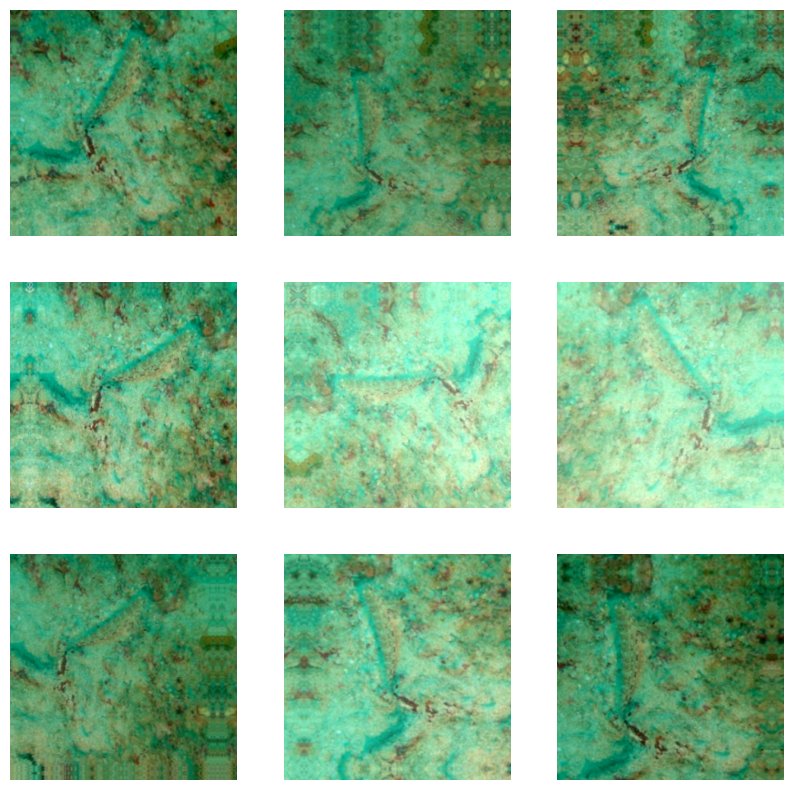

In [26]:
import matplotlib.pyplot as plt

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [27]:
# Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Define the inputs and apply augmentation
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Define family output
family_output = tf.keras.layers.Dense(len(family_labels), activation='softmax', name='family')(x)

# Concatenate the family output with the base model output
family_features = tf.keras.layers.Concatenate()([x, family_output])

# Define genus output, using family features as additional input
genus_hidden = tf.keras.layers.Dense(256, activation='relu')(family_features)
genus_output = tf.keras.layers.Dense(len(genus_labels), activation='softmax', name='genus')(genus_hidden)

# Concatenate the family and genus outputs with the base model output
genus_features = tf.keras.layers.Concatenate()([x, family_output, genus_output])

# Define species output, using both family and genus features as additional input
species_hidden = tf.keras.layers.Dense(256, activation='relu')(genus_features)
species_output = tf.keras.layers.Dense(len(species_labels), activation='softmax', name='species')(species_hidden)

# Create the hierarchical model
model = tf.keras.Model(inputs, [family_output, genus_output, species_output])


base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss={
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

# %%
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 299, 299,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_2       │ (None, 299, 299,  │          0 │ sequential_2[0][… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 299, 299,  │          0 │ true_divide_2[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 10, 10,    │ 23,564,800 │ subtract_2[0][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │     36,882 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 2066)      │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ family[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    529,152 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 45)        │     11,565 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 2111)      │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ family[0][0],     │
│                     │                   │            │ genus[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    540,672 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 57)        │     14,649 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,697,720 (94.21 MB)

 Trainable params: 1,132,920 (4.32 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [28]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification.
    gamma: focusing parameter. Higher values make the model focus more on hard-to-classify samples.
    alpha: balancing parameter. Controls the balance between classes.
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)  # Avoid division by zero
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    
    return focal_loss_fixed

# Apply focal loss to each output layer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss={
        'family': focal_loss(gamma=2., alpha=0.25),
        'genus': focal_loss(gamma=2., alpha=0.25),
        'species': focal_loss(gamma=2., alpha=0.25),
    },
    metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy'],
    }
)

In [29]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 78s 403ms/step - family_accuracy: 0.2055 - family_loss: 0.5794 - genus_accuracy: 0.1945 - genus_loss: 0.7726 - loss: 2.2252 - species_accuracy: 0.1435 - species_loss: 0.8732 - val_family_accuracy: 0.4489 - val_family_loss: 0.3715 - val_genus_accuracy: 0.5635 - val_genus_loss: 0.4119 - val_loss: 1.2931 - val_species_accuracy: 0.5055 - val_species_loss: 0.5068
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 70s 389ms/step - family_accuracy: 0.4085 - family_loss: 0.3652 - genus_accuracy: 0.5386 - genus_loss: 0.3895 - loss: 1.2338 - species_accuracy: 0.4937 - species_loss: 0.4791 - val_family_accuracy: 0.5877 - val_family_loss: 0.2641 - val_genus_accuracy: 0.6913 - val_genus_loss: 0.2550 - val_loss: 0.8321 - val_species_accuracy: 0.6568 - val_species_loss: 0.3107
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 71s 391ms/step - family_accuracy: 0.5354 - family_loss: 0.2696 - genus_accuracy: 0.6828 - genus_loss: 0.2477 - loss: 0.8166 - species_accuracy: 0.6490 - speci

In [30]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - family_accuracy: 0.7962 - family_loss: 0.1053 - genus_accuracy: 0.8617 - genus_loss: 0.0867 - loss: 0.2897 - species_accuracy: 0.8368 - species_loss: 0.0978
Family Acc: 0.813
Genus Acc: 0.867
Species Acc: 0.843


In [31]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [33]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  loss=focal_loss(gamma=2., alpha=0.25), 
  metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy']
    }
)

In [34]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
)

Epoch 11/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 107s 548ms/step - family_accuracy: 0.7370 - family_loss: 0.1341 - genus_accuracy: 0.7969 - genus_loss: 0.1253 - loss: 0.4001 - species_accuracy: 0.7888 - species_loss: 0.1408 - val_family_accuracy: 0.8591 - val_family_loss: 0.0657 - val_genus_accuracy: 0.8805 - val_genus_loss: 0.0708 - val_loss: 0.2129 - val_species_accuracy: 0.8709 - val_species_loss: 0.0744
Epoch 12/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 526ms/step - family_accuracy: 0.8073 - family_loss: 0.0872 - genus_accuracy: 0.8702 - genus_loss: 0.0730 - loss: 0.2383 - species_accuracy: 0.8678 - species_loss: 0.0781 - val_family_accuracy: 0.8826 - val_family_loss: 0.0538 - val_genus_accuracy: 0.8909 - val_genus_loss: 0.0642 - val_loss: 0.1842 - val_species_accuracy: 0.8812 - val_species_loss: 0.0685
Epoch 13/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 527ms/step - family_accuracy: 0.8439 - family_loss: 0.0699 - genus_accuracy: 0.8932 - genus_loss: 0.0544 - loss: 0.1862 - species_accuracy: 0.8870 - s

In [35]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - family_accuracy: 0.9385 - family_loss: 0.0293 - genus_accuracy: 0.9242 - genus_loss: 0.0396 - loss: 0.1108 - species_accuracy: 0.9185 - species_loss: 0.0419
Family Acc: 0.937
Genus Acc: 0.924
Species Acc: 0.923


In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path, model, family_labels, genus_labels, species_labels, top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [299, 299])
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], [299, 299]) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


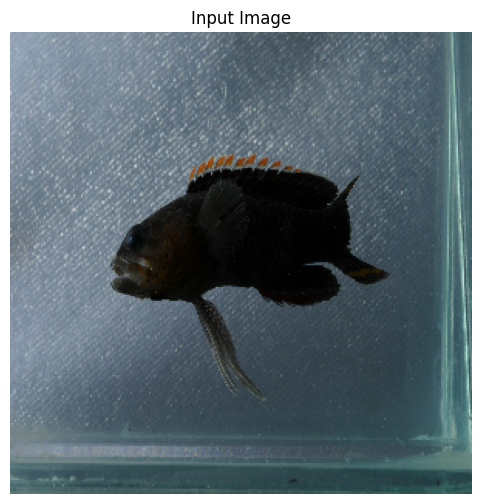

Top 3 Family Predictions:
b'Plesiopidae': 0.9503
b'Blenniidae': 0.0164
b'Pomacanthidae': 0.0067

Top 3 Genus Predictions:
b'Plesiops': 0.9860
b'Cirripectes': 0.0087
b'Enchelyurus': 0.0042

Top 3 Species Predictions:
b'Plesiops coeruleolineatus': 0.9882
b'Enchelyurus ater': 0.0049
b'Cirripectes variolosus': 0.0025


In [45]:
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/66367_web_Eviota_melasma_6.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Trimma_macrophthalmus/21775_web_Trimma_macrophthalmus_32.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Istigobius_decoratus/21689_web_Istigobius_decoratus_441.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Istigobius_decoratus/86970_web_Istigobius_decoratus_496.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Trimma_macrophthalmus/65426378_fish_photo_10654.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/96590_web_Eviota_melasma_60.jpeg'
image_path = '/Volumes/T7_shield/CryptoVision/Data/new_dataset/Site J - Site K/JMC_8142.JPG'

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

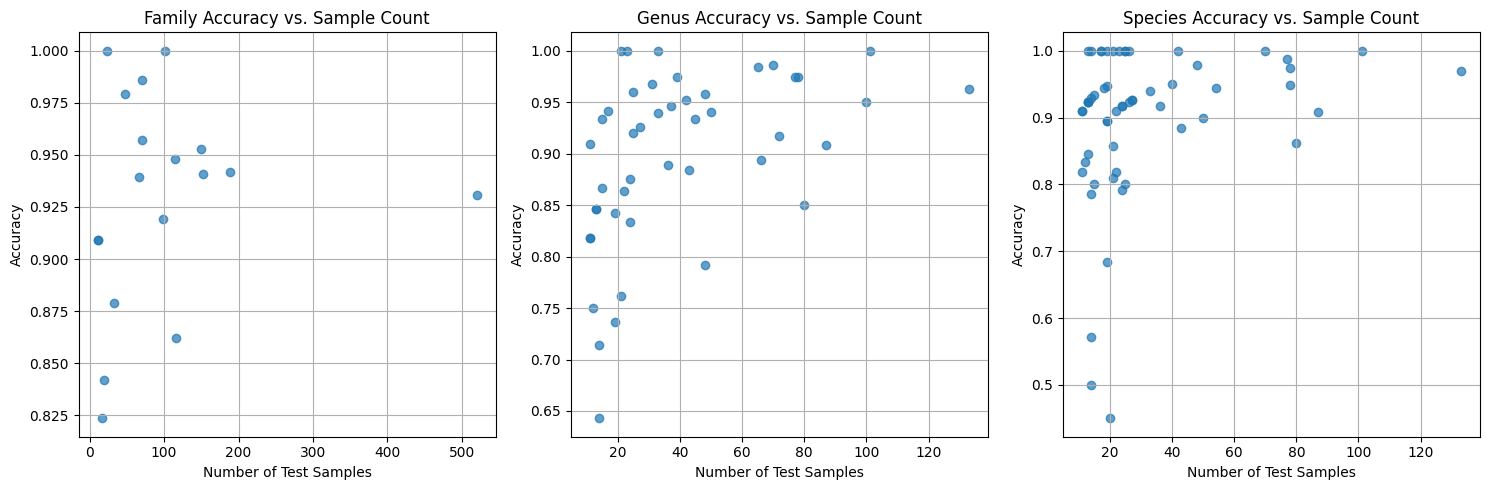

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def evaluate_accuracy_per_label(test_ds, model, family_labels, genus_labels, species_labels):
    # Initialize dictionaries to store correct predictions and counts for each label
    family_correct = defaultdict(int)
    genus_correct = defaultdict(int)
    species_correct = defaultdict(int)
    
    family_total = defaultdict(int)
    genus_total = defaultdict(int)
    species_total = defaultdict(int)

    # Iterate over the test dataset
    for images, labels in test_ds:
        # Get true labels
        true_family = tf.argmax(labels["family"], axis=1).numpy()
        true_genus = tf.argmax(labels["genus"], axis=1).numpy()
        true_species = tf.argmax(labels["species"], axis=1).numpy()

        # Get model predictions
        family_preds, genus_preds, species_preds = model.predict(images)
        pred_family = np.argmax(family_preds, axis=1)
        pred_genus = np.argmax(genus_preds, axis=1)
        pred_species = np.argmax(species_preds, axis=1)

        # Update counts for each label
        for true_fam, pred_fam, true_gen, pred_gen, true_spe, pred_spe in zip(
            true_family, pred_family, true_genus, pred_genus, true_species, pred_species
        ):
            # Update family counts
            family_total[true_fam] += 1
            if true_fam == pred_fam:
                family_correct[true_fam] += 1

            # Update genus counts
            genus_total[true_gen] += 1
            if true_gen == pred_gen:
                genus_correct[true_gen] += 1

            # Update species counts
            species_total[true_spe] += 1
            if true_spe == pred_spe:
                species_correct[true_spe] += 1

    # Calculate accuracy for each label
    family_accuracy = {family_labels[k]: family_correct[k] / family_total[k] for k in family_total if family_total[k] > 0}
    genus_accuracy = {genus_labels[k]: genus_correct[k] / genus_total[k] for k in genus_total if genus_total[k] > 0}
    species_accuracy = {species_labels[k]: species_correct[k] / species_total[k] for k in species_total if species_total[k] > 0}
    
    # Create dataframes for plotting
    family_df = pd.DataFrame({
        'Label': list(family_accuracy.keys()),
        'Accuracy': list(family_accuracy.values()),
        'Count': [family_total[family_labels.index(label)] for label in family_accuracy.keys()]
    })
    
    genus_df = pd.DataFrame({
        'Label': list(genus_accuracy.keys()),
        'Accuracy': list(genus_accuracy.values()),
        'Count': [genus_total[genus_labels.index(label)] for label in genus_accuracy.keys()]
    })
    
    species_df = pd.DataFrame({
        'Label': list(species_accuracy.keys()),
        'Accuracy': list(species_accuracy.values()),
        'Count': [species_total[species_labels.index(label)] for label in species_accuracy.keys()]
    })

    # Plot the correlations
    plt.figure(figsize=(15, 5))

    # Family plot
    plt.subplot(1, 3, 1)
    plt.scatter(family_df['Count'], family_df['Accuracy'], alpha=0.7)
    plt.title('Family Accuracy vs. Sample Count')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Genus plot
    plt.subplot(1, 3, 2)
    plt.scatter(genus_df['Count'], genus_df['Accuracy'], alpha=0.7)
    plt.title('Genus Accuracy vs. Sample Count')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Species plot
    plt.subplot(1, 3, 3)
    plt.scatter(species_df['Count'], species_df['Accuracy'], alpha=0.7)
    plt.title('Species Accuracy vs. Sample Count')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return family_df, genus_df, species_df

# Usage
family_df, genus_df, species_df = evaluate_accuracy_per_label(
    test_ds, model, family_labels, genus_labels, species_labels
)

Confusion Matrix for Family:


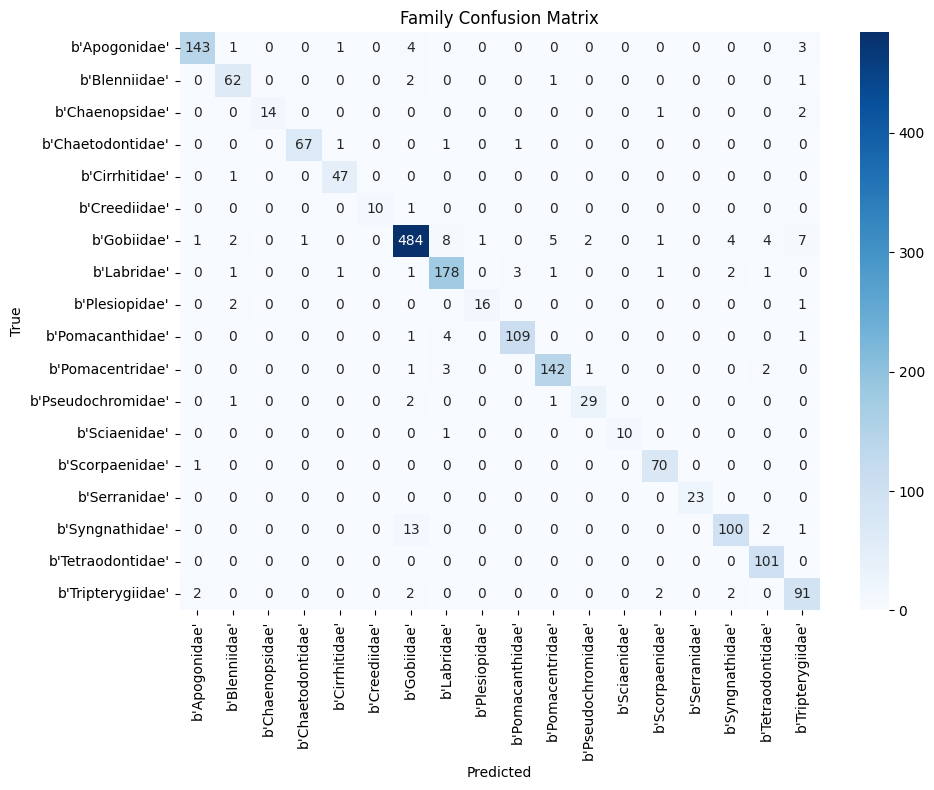

Confusion Matrix for Genus:


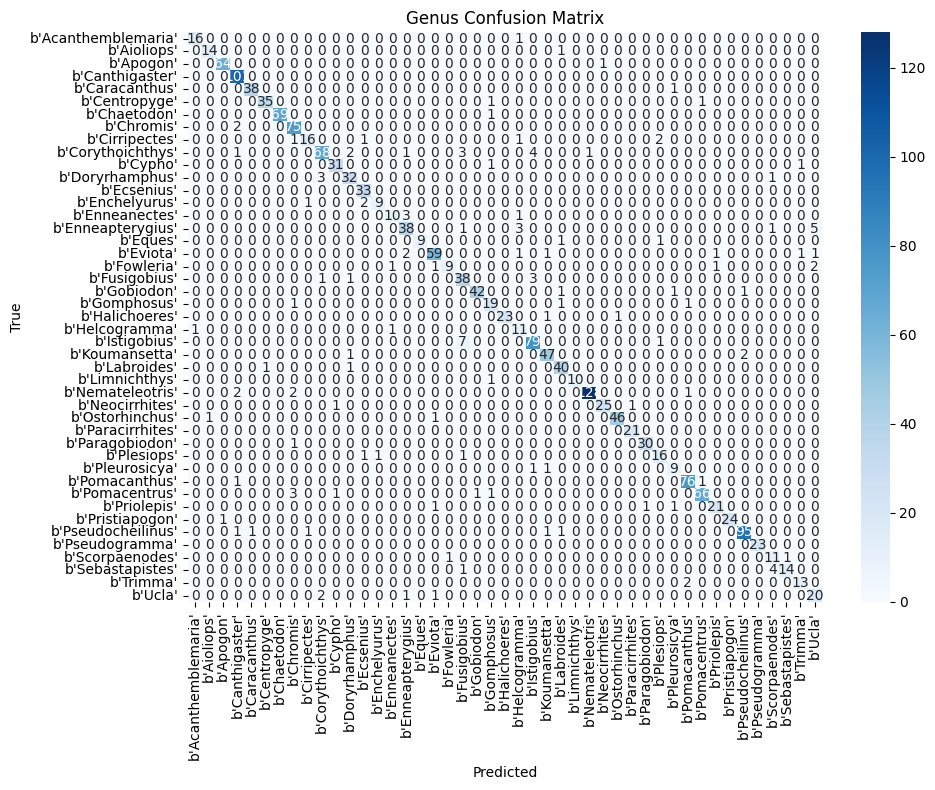

Confusion Matrix for Species:


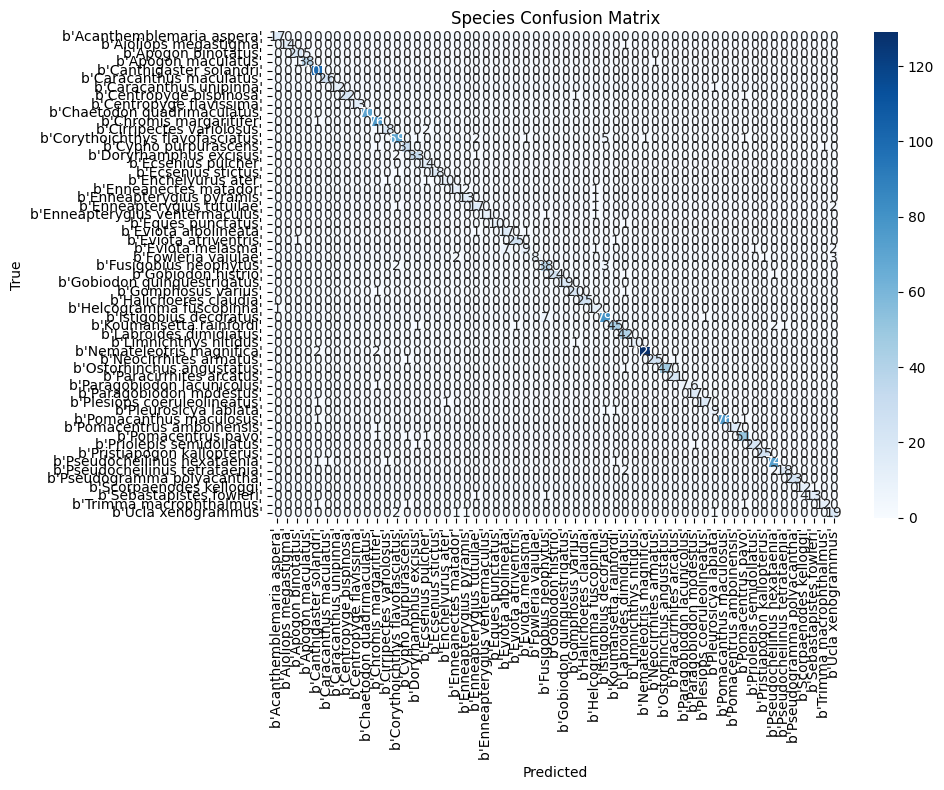

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def get_predictions_and_labels(model, dataset, label_type):
    """
    Get true labels and predictions for a specific output type from a dataset.
    
    Args:
    - model (tf.keras.Model): The trained model.
    - dataset (tf.data.Dataset): Dataset to predict on.
    - label_type (str): Type of label to extract ('family', 'genus', or 'species').
    
    Returns:
    - y_true (list): List of true labels.
    - y_pred (list): List of predicted labels.
    """
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        # Predict with the model
        family_logits, genus_logits, species_logits = model(images, training=False)
        
        if label_type == 'family':
            logits = family_logits
            true_labels = tf.argmax(labels['family'], axis=1).numpy()
        elif label_type == 'genus':
            logits = genus_logits
            true_labels = tf.argmax(labels['genus'], axis=1).numpy()
        elif label_type == 'species':
            logits = species_logits
            true_labels = tf.argmax(labels['species'], axis=1).numpy()
        
        # Get the predicted labels
        pred_labels = np.argmax(logits, axis=1)
        
        # Append to lists
        y_true.extend(true_labels)
        y_pred.extend(pred_labels)
    
    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plot a confusion matrix using true and predicted labels.
    
    Args:
    - y_true (list): True labels.
    - y_pred (list): Predicted labels.
    - class_names (list): List of class names.
    - title (str): Title for the confusion matrix plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Example usage: Generate and plot confusion matrices for family, genus, and species
family_y_true, family_y_pred = get_predictions_and_labels(model, test_ds, label_type='family')
genus_y_true, genus_y_pred = get_predictions_and_labels(model, test_ds, label_type='genus')
species_y_true, species_y_pred = get_predictions_and_labels(model, test_ds, label_type='species')

# Plot confusion matrices
print("Confusion Matrix for Family:")
plot_confusion_matrix(family_y_true, family_y_pred, family_labels, title='Family Confusion Matrix')

print("Confusion Matrix for Genus:")
plot_confusion_matrix(genus_y_true, genus_y_pred, genus_labels, title='Genus Confusion Matrix')

print("Confusion Matrix for Species:")
plot_confusion_matrix(species_y_true, species_y_pred, species_labels, title='Species Confusion Matrix')

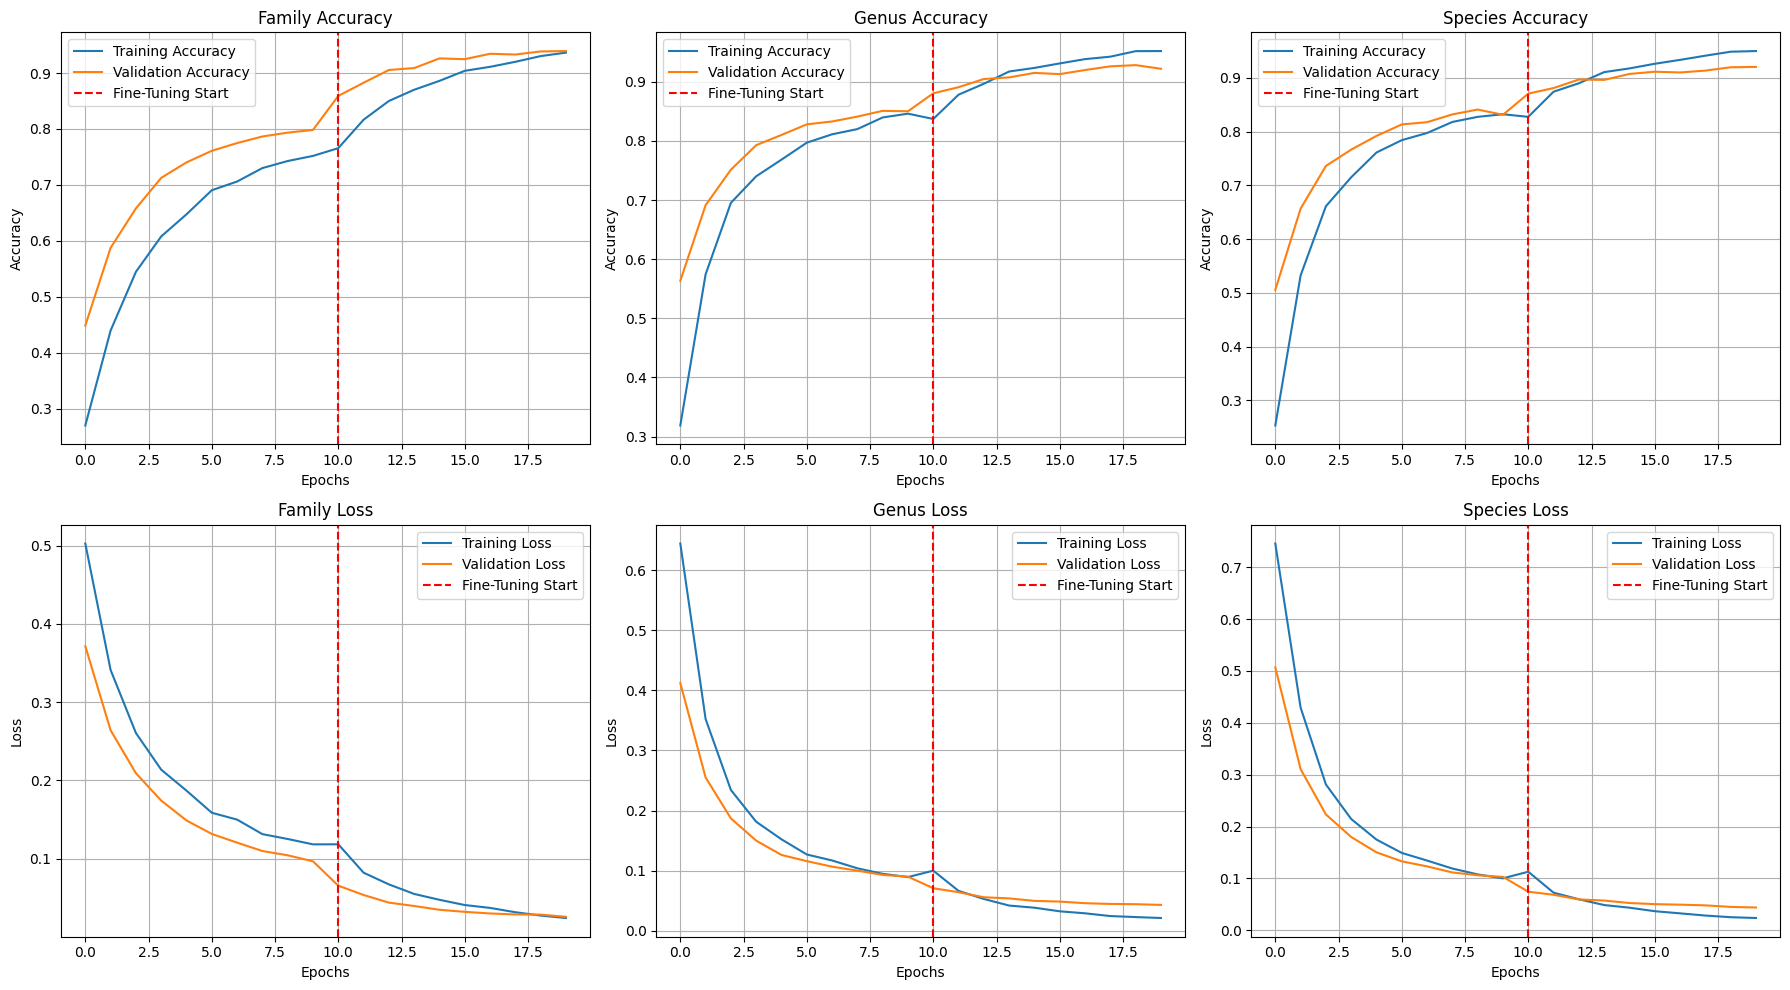

In [52]:
import matplotlib.pyplot as plt

def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# fine_tune_at = len(history.epoch)  # Get the epoch where fine-tuning started
plot_training_history(history, history_fine, fine_tune_at=10)